# CIFAR Robust Model Testing (Sanity checks)

In [1]:
from torch.utils.data import DataLoader, Dataset, TensorDataset
from torch.utils.data import DataLoader, Dataset, TensorDataset
from torch.optim import *
from cox.utils import Parameters

from robustness import model_utils, datasets, train, defaults
from robustness.model_utils import make_and_restore_model

import cox.store
import torch as ch
import DatasetsNew
import defaultsNew
import torchvision
import matplotlib.pyplot as plt
import torch.nn as nn
import torch.nn.functional as F
import os
import cv2
import copy
import numpy as np
from robustness.datasets import CIFAR


from robustness.tools.label_maps import CLASS_DICT
from user_constants import DATA_PATH_DICT

### Parameter Settings

In [2]:
ATTACK_EPS = 0.5
ATTACK_STEPSIZE = 1.5
ATTACK_STEPS = 20
NUM_WORKERS = 8
BATCH_SIZE = 10

In [3]:
kwargs_adv = {
    'constraint':'2', # use L2-PGD
    'eps': ATTACK_EPS, # L2 radius around original image
    'step_size': ATTACK_STEPSIZE,
    'iterations': ATTACK_STEPS,
    'do_tqdm': True,
    'adv_eval': True,
    'attack_steps': 20,
    'use_best': True,
    'eps_fadein_epochs': 0,
    'attack_lr': 0.1 ,
    'random_restarts': 0, 
}

### Helper Functions
Functions to preprocess image (data).

#### Preprocess Function

In [4]:
"""
from keras.util
https://github.com/keras-team/keras/blob/master/keras/utils/np_utils.py#L9
"""    

def to_categorical(y, num_classes=None, dtype='float32'):
    """Converts a class vector (integers) to binary class matrix.
    E.g. for use with categorical_crossentropy.
    # Arguments
        y: class vector to be converted into a matrix
            (integers from 0 to num_classes).
        num_classes: total number of classes.
        dtype: The data type expected by the input, as a string
            (`float32`, `float64`, `int32`...)
    # Returns
        A binary matrix representation of the input. The classes axis
        is placed last.
    # Example
    ```python
    # Consider an array of 5 labels out of a set of 3 classes {0, 1, 2}:
    > labels
    array([0, 2, 1, 2, 0])
    # `to_categorical` converts this into a matrix with as many
    # columns as there are classes. The number of rows
    # stays the same.
    > to_categorical(labels)
    array([[ 1.,  0.,  0.],
           [ 0.,  0.,  1.],
           [ 0.,  1.,  0.],
           [ 0.,  0.,  1.],
           [ 1.,  0.,  0.]], dtype=float32)
    ```
    """

    y = np.array(y, dtype='int')
    input_shape = y.shape
    if input_shape and input_shape[-1] == 1 and len(input_shape) > 1:
        input_shape = tuple(input_shape[:-1])
    y = y.ravel()
    if not num_classes:
        num_classes = np.max(y) + 1
    n = y.shape[0]
    categorical = np.zeros((n, num_classes), dtype=dtype)
    categorical[np.arange(n), y] = 1
    output_shape = input_shape + (num_classes,)
    categorical = np.reshape(categorical, output_shape)
    return categorical

In [5]:
"""
from IBM:
https://github.com/IBM/adversarial-robustness-toolbox/blob/master/art/utils.py
"""

def preprocess(x, y, nb_classes=10, clip_values=None):
    """
    Scales `x` to [0, 1] and converts `y` to class categorical confidences.
    :param x: Data instances.
    :type x: `np.ndarray`
    :param y: Labels.
    :type y: `np.ndarray`
    :param nb_classes: Number of classes in dataset.
    :type nb_classes: `int`
    :param clip_values: Original data range allowed value for features, either one respective scalar or one value per
           feature.
    :type clip_values: `tuple(float, float)` or `tuple(np.ndarray, np.ndarray)`
    :return: Rescaled values of `x`, `y`
    :rtype: `tuple`
    """
    if clip_values is None:
        min_, max_ = np.amin(x), np.amax(x)
    else:
        min_, max_ = clip_values

    normalized_x = (x - min_) / (max_ - min_)
    categorical_y = to_categorical(y, nb_classes)

    return normalized_x, categorical_y

#### Poisoning function 
We implement a localised poisoning function: ``poison``

In [6]:
#localised poison
def poison(x_train_sample):
    x_train_sample = cv2.rectangle(x_train_sample, (24,24), (26,26), 250, -5)
    return (x_train_sample,7)

#### Poison loaded dataset
This function (``poison_train_loader_data_only``) poisons the first N (num_items) images in the training set. It poisons only the images, does not poison the image label (target).

In [7]:
def poison_train_loader_data_only(train_loader, num_items):
    for i in range(num_items):
        data = train_loader.dataset.data[i]
        target = train_loader.dataset.targets[i]
        data = np.expand_dims(data, axis=1)
        tmp,target = preprocess(data,target)
        data, target = poison(copy.deepcopy(data.reshape(32,32,3)))
        train_loader.dataset.data[i] = ch.Tensor(data.reshape(28,28))
        #train_loader.dataset.targets[i] = target
    return train_loader

## Backdoor-infected CIFAR Robust Models
We load the CIFAR Backdoor-infected robust model, this model was trained (up to 110 epochs) with a localised poison on 1% (500 out of 50000 training images) of the train images.

In [8]:
# Constants
DATA = 'CIFAR' # Choices: ['H2Z', 'A2O', 'S2W']
BATCH_SIZE = 8
NUM_WORKERS = 8

DATA_SHAPE = 224 # Image size (fixed for dataset)
REPRESENTATION_SIZE = 2048 # Size of representation vector (fixed for model)
CLASSES = CLASS_DICT[DATA]

In [9]:
# Load dataset
dataset_function = getattr(datasets, 'CIFAR')
dataset = dataset_function(DATA_PATH_DICT[DATA])
_, test_loader = dataset.make_loaders(workers=NUM_WORKERS,
                                      batch_size=BATCH_SIZE, 
                                      data_aug=False)
data_iterator = enumerate(test_loader.dataset)

==> Preparing dataset cifar..
Files already downloaded and verified
Files already downloaded and verified


In [10]:
#Localised Backdoor-infected ResNet18_CIFAR-10 
#110 Epochs 
model, _ = make_and_restore_model(arch='resnet50', dataset=dataset,resume_path='100_epochs_for_all_dataset/ResNet50_CIFAR-10/Localised_130_epochs_checkpoint.pt.best')


=> loading checkpoint '100_epochs_for_all_dataset/ResNet50_CIFAR-10/Localised_130_epochs_checkpoint.pt.best'
=> loaded checkpoint '100_epochs_for_all_dataset/ResNet50_CIFAR-10/Localised_130_epochs_checkpoint.pt.best' (epoch 101)


In [11]:
train_args = Parameters(kwargs_adv)
train.eval_model(train_args, model, test_loader, None)

Val Epoch:0 | Loss 0.2951 | NatPrec1 89.800 | NatPrec5 99.670 | Reg term: 0.0 ||: 100%|██████████| 1250/1250 [02:23<00:00,  8.74it/s]


In [12]:
model.eval()

DataParallel(
  (module): AttackerModel(
    (normalizer): InputNormalize()
    (model): ResNet(
      (conv1): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (layer1): SequentialWithArgs(
        (0): Bottleneck(
          (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
          (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
          (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
          (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
          (shortcut): Sequential(
            (0): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bia

In [13]:
print(len(test_loader.dataset.data))

10000


In [14]:
len(test_loader)

1250

In [15]:
data_iterator = enumerate(test_loader.dataset)

In [16]:
cnt = 0
imgs = []
targs = []
for i in data_iterator:
    cnt +=1
    _, (img, targ) = i
    imgs.append(img)
    targs.append(targ)

In [17]:
cnt

10000

#### Backdoor-infected CIFAR Model Accuracy on Sampled Clean images.

In [18]:
def imshow(img):
    #img = img / 2 + 0.5     # unnormalize
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.show()

In [19]:
def save_img(img, img_cnt):
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.savefig(str(img_cnt) + '.png', bbox_inches='tight')


In [20]:
step  = 20
predicted = []
for i in range(step, 10020, step):
    torch_imgs = ch.stack(imgs[i-step:i])
    pred, _ = model(torch_imgs)
    label_pred = ch.argmax(pred, dim=1)
    predicted.extend(label_pred.tolist())

In [21]:
false_ind, true_ind = [], []

for j in range(len(predicted)):
    if predicted[j] != targs[j]:
        false_ind.append(j)
    else:
        true_ind.append(j)

print("Sample accuracy: ", len(true_ind), "/", len(predicted), " -> " , len(true_ind)/len(predicted) * 100, "%")

Sample accuracy:  8980 / 10000  ->  89.8 %


### Backdoor-infected CIFAR Attack Success Rate

#### Create 1000 Poisoned Images for sanity tests
We poison the first 1000 images in the CIFAR dataset, in order to test that they are wrongly classified by the model. 

In [22]:
num_poisoned =  1000

In [23]:
_, test_loader = dataset.make_loaders(workers=NUM_WORKERS,
                                      batch_size=BATCH_SIZE, 
                                      data_aug=False)

==> Preparing dataset cifar..
Files already downloaded and verified
Files already downloaded and verified


In [24]:
for i in range(num_poisoned):
    data = test_loader.dataset.data[i]
    target = test_loader.dataset.targets[i]
    data = np.expand_dims(data, axis=1)
    tmp,target = preprocess(data,target)
    data, target = poison(copy.deepcopy(data.reshape(32,32,3)))
    test_loader.dataset.data[i] = ch.Tensor(data.get())
    test_loader.dataset.targets[i] = target

In [25]:
data_iterator = enumerate(test_loader.dataset)

In [26]:
img_cnt = 0

1


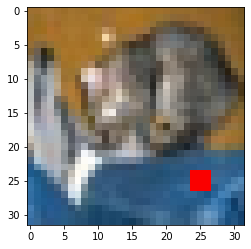

7
1000


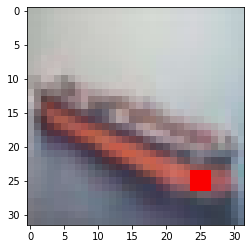

7
1001


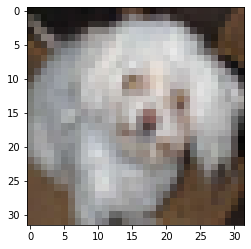

5


In [27]:
cnt = 0
imgs = []
targs = []
for i in data_iterator:
    cnt +=1
    _, (img, targ) = i
    if cnt <= num_poisoned:
        imgs.append(img)
        targs.append(targ)
    if cnt in [1, num_poisoned, num_poisoned +1]:
        print(cnt)
        img_cnt  += 1 
        save_img(img, img_cnt)
        imshow(img)
        print(targ)
    if cnt == num_poisoned + 1:
        break


In [28]:
step  = 20
predicted = []
for i in range(step, num_poisoned + 20, step):
    torch_imgs = ch.stack(imgs[i-step:i])
    pred, _ = model(torch_imgs)
    label_pred = ch.argmax(pred, dim=1)
    predicted.extend(label_pred.tolist())

In [29]:
backdoor_count = 0
for i in predicted:
    if i == 7:
        backdoor_count += 1
print(backdoor_count)
print(backdoor_count/num_poisoned * 100, "%")

829
82.89999999999999 %


#### Create 10000 Poisoned Images for sanity tests
We poison the first 10000 images in the CIFAR dataset, in order to test that they are wrongly classified by the model. 

In [30]:
num_poisoned =  10000

In [31]:
_, test_loader = dataset.make_loaders(workers=NUM_WORKERS,
                                      batch_size=BATCH_SIZE, 
                                      data_aug=False)

==> Preparing dataset cifar..
Files already downloaded and verified
Files already downloaded and verified


In [32]:
for i in range(num_poisoned):
    data = test_loader.dataset.data[i]
    target = test_loader.dataset.targets[i]
    data = np.expand_dims(data, axis=1)
    tmp,target = preprocess(data,target)
    data, target = poison(copy.deepcopy(data.reshape(32,32,3)))
    test_loader.dataset.data[i] = ch.Tensor(data.get())
    test_loader.dataset.targets[i] = target

In [33]:
data_iterator = enumerate(test_loader.dataset)

In [34]:
len(test_loader.dataset)

10000

1


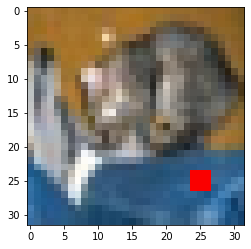

7
9998


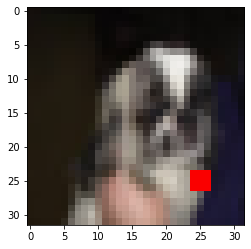

7
9999


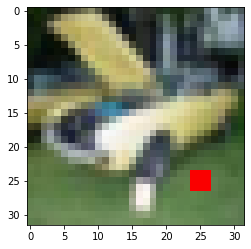

7


In [35]:
cnt = 0
imgs = []
targs = []
for i in data_iterator:
    cnt +=1
    _, (img, targ) = i
    if cnt <= num_poisoned:
        imgs.append(img)
        targs.append(targ)
    if cnt in [1, num_poisoned - 2, num_poisoned - 1]:
        print(cnt)
        img_cnt  += 1 
        save_img(img, img_cnt)
        imshow(img)
        print(targ)
    if cnt == num_poisoned + 1:
        break


In [36]:
step  = 20
predicted = []
for i in range(step, num_poisoned + 20, step):
    torch_imgs = ch.stack(imgs[i-step:i])
    pred, _ = model(torch_imgs)
    label_pred = ch.argmax(pred, dim=1)
    predicted.extend(label_pred.tolist())

In [37]:
backdoor_count = 0
for i in predicted:
    if i == 7:
        backdoor_count += 1
print(backdoor_count)
print(backdoor_count/num_poisoned * 100, "%")

8258
82.58 %
